In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#device detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
#creating dataset
np.random.seed(0)
torch.manual_seed(0)

X = np.random.randn(1000, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [7]:
#data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [11]:
#create model object again
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN().to(device)

In [13]:
#creating loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
#gpu aware training loop
epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):

    # ---- TRAIN ----
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)

    # ---- VALIDATION ----
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch 01 | Train: 0.3394 | Val: 0.0654
Epoch 02 | Train: 0.0461 | Val: 0.0280
Epoch 03 | Train: 0.0263 | Val: 0.0243
Epoch 04 | Train: 0.0244 | Val: 0.0180
Epoch 05 | Train: 0.0181 | Val: 0.0319
Epoch 06 | Train: 0.0207 | Val: 0.0169
Epoch 07 | Train: 0.0197 | Val: 0.0165
Epoch 08 | Train: 0.0194 | Val: 0.0544
Epoch 09 | Train: 0.0329 | Val: 0.0409
Epoch 10 | Train: 0.0190 | Val: 0.0217
Epoch 11 | Train: 0.0147 | Val: 0.0228
Epoch 12 | Train: 0.0183 | Val: 0.0137
Epoch 13 | Train: 0.0142 | Val: 0.0189
Epoch 14 | Train: 0.0143 | Val: 0.0229
Epoch 15 | Train: 0.0176 | Val: 0.0201
Epoch 16 | Train: 0.0117 | Val: 0.0151
Epoch 17 | Train: 0.0198 | Val: 0.0127
Epoch 18 | Train: 0.0289 | Val: 0.0597
Epoch 19 | Train: 0.0170 | Val: 0.0090
Epoch 20 | Train: 0.0198 | Val: 0.0470


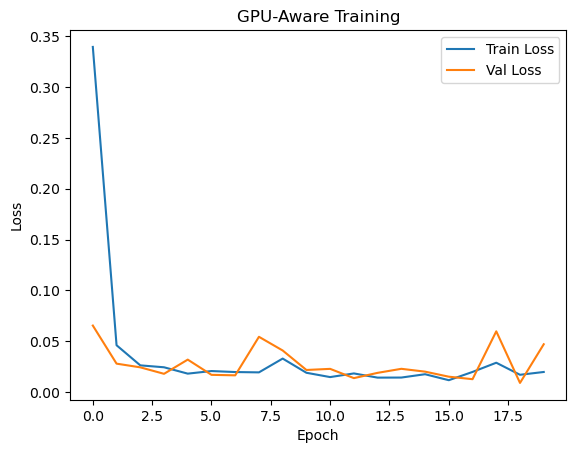

In [17]:
#plot loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GPU-Aware Training")
plt.show()

In [19]:
#check validation accuracy
model.eval()
with torch.no_grad():
    logits = model(X_val.to(device))
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    acc = preds.eq(y_val.to(device)).float().mean().item()

print("Validation Accuracy:", acc)

Validation Accuracy: 0.984000027179718


## Objective
Implement GPU-aware PyTorch training using:

- Automatic device detection
- Moving model & tensors to device
- Device-agnostic training loop

This pattern is essential for scalable deep learning workflows.
## Key Takeaways

- Device detection enables portable training across CPU/GPU.
- Both model and tensors must be moved to the same device.
- GPU acceleration significantly improves training speed for large models/datasets.
- Device-agnostic code is standard practice in professional ML workflows.